Pneumonia is one of the leading respiratory illnesses worldwide, and its timely and accurate diagnosis is essential for effective treatment. Manually reviewing chest X-rays is a critical step in this process, and AI can provide valuable support by helping to expedite the assessment. In your role as a consultant data scientist, you will test the ability of a deep learning model to distinguish pneumonia cases from normal images of lungs in chest X-rays.

By fine-tuning a pre-trained convolutional neural network, specifically the ResNet-18 model, your task is to classify X-ray images into two categories: normal lungs and those affected by pneumonia. You can leverage its already trained weights and get an accurate classifier trained faster and with fewer resources.

## The Data


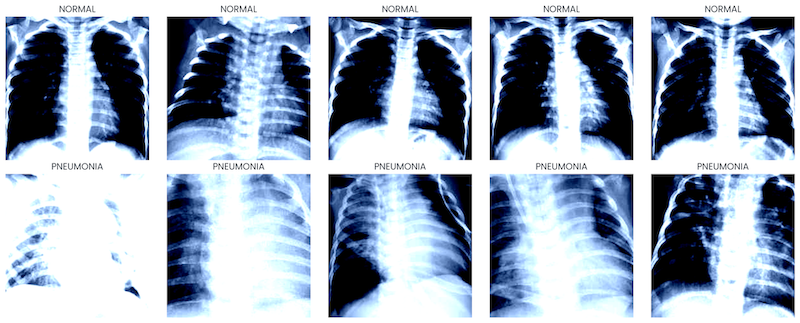

We have a dataset of chest X-rays that have been preprocessed for use with a ResNet-18 model. You can see a sample of 5 images from each category above. Upon unzipping the `chestxrays.zip` file (code provided below), you will find your dataset inside the `data/chestxrays` folder divided into `test` and `train` folders.

There are 150 training images and 50 testing images for each category, NORMAL and PNEUMONIA (300 and 100 in total). For your convenience, this data has already been loaded into a `train_loader` and a `test_loader` using the `DataLoader` class from the PyTorch library.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchmetrics

# Import required libraries
# -------------------------
# Data loading
import random
import numpy as np
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Train model
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Evaluate model
from torchmetrics import Accuracy, F1Score

# Set random seeds for reproducibility
torch.manual_seed(101010)
np.random.seed(101010)
random.seed(101010)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.3 MB/s eta 0:00:00


Setting the Environment First, we import the necessary PyTorch libraries (torch, torchvision) for building and training the neural network. We also set "seeds" for the random number generators. This ensures that every time we run this notebook, the results (random shuffling, weight initialization) are exactly the same, which is crucial for reproducibility.

In [9]:
import os
import zipfile
import shutil

# Unzip the data folder
# Define the target directory for extraction
target_dir = 'data/chestxrays'

# Remove the target directory if it already exists to ensure a clean extraction
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

# Create the base 'data' directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Extract the zip file
with zipfile.ZipFile('/content/drive/MyDrive/CNN Data/data/chestxrays.zip', 'r') as zip_ref:
    # Extract to the 'data' directory. This will create 'data/chestxrays' if the zip contains it.
    zip_ref.extractall('data')

Extracting the Data Here we check if the data folder already exists. If not, we unzip the chestxrays.zip file. This creates our directory structure containing the train and test image folders.

In [10]:
import os, random, shutil

# Function to move 50 random files from class folder in training to validation folder
def move_files(src_class_dir, dest_class_dir, n=50):
    if not os.path.exists(dest_class_dir):
        os.makedirs(dest_class_dir)
    files = os.listdir(src_class_dir)
    # Ensure we don't try to move more files than exist
    n = min(n, len(files))
    random_files = random.sample(files, n)
    for f in random_files:
        shutil.move(os.path.join(src_class_dir, f), os.path.join(dest_class_dir, f))

# Move 50 images from each class to validation folder
# We check if the validation folder exists first to avoid moving files twice if you rerun the cell
if not os.path.exists('data/chestxrays/val/NORMAL'):
    move_files('data/chestxrays/train/NORMAL', 'data/chestxrays/val/NORMAL')
    move_files('data/chestxrays/train/PNEUMONIA', 'data/chestxrays/val/PNEUMONIA')

Creating a Validation Set Before we load the data into the model, we need to physically prepare our folders. This code takes 50 random images from the training folder and moves them into a new val (validation) folder. This creates a "hold-out" dataset we can use to tune the model without touching the final test data.

In [17]:
# Augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Ensure consistent size
    transforms.RandomHorizontalFlip(),   # Mirror image (lungs are symmetric-ish)
    transforms.RandomRotation(10),       # Rotate +/- 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Slight lighting changes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# No augmentation for testing/validation (just resizing and normalizing)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Update datasets with specific transforms
train_dataset = ImageFolder('data/chestxrays/train', transform=train_transform)
test_dataset = ImageFolder('data/chestxrays/test', transform=test_transform)

reprocessing and Loading We define a set of transformations to prepare the images. This includes converting them to PyTorch Tensors and normalizing their color channels using the specific mean and standard deviation values that the ResNet model expects (derived from the ImageNet dataset). We then wrap these datasets in DataLoader objects, which handle batching and shuffling during training.

In [18]:
# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Importing ResNet-18 We download the ResNet-18 architecture with pre-trained weights (DEFAULT). This model has already learned to recognize complex features (like edges and shapes) from a massive dataset, which saves us from training a model from scratch.

In [19]:
# Freeze the parameters of the model
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the final layer for binary classification
resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)

Freezing and Modifying the Network This is the Transfer Learning step.

We freeze the parameters of the original model so they don't get updated during training. We want to keep the knowledge it already has.

We replace the final layer (fc). The original ResNet has 1000 outputs; we change this to a new Linear layer with only 1 output (since we are doing binary classification: Pneumonia vs. Normal).

In [20]:
# Model training/fine-tuning loop
def train(model, train_loader, criterion, optimizer, num_epochs):

    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_accuracy = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Ensure labels have the same dimensions as outputs
            labels = labels.float().unsqueeze(1)

            # Forward pass
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5 # Binary classification
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy for the current epoch
        train_loss = running_loss / len(train_dataset)
        train_acc = running_accuracy.double() / len(train_dataset)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc))

Defining the Train Function We define a function train that handles the learning process. For every "epoch" (full pass through the data), it:

* Makes predictions (Forward pass).

* Calculates how wrong the predictions were (Loss).

* Calculates the gradients (Backward pass).

* Updates the model weights to reduce error (Optimizer step).




In [22]:
# Set the model to ResNet-18
model = resnet18

# Fine-tune the ResNet-18 model for 3 epochs using the train_loader
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
train(model, train_loader, criterion, optimizer, num_epochs=15)

Epoch [1/15], train loss: 0.4036, train acc: 0.8350
Epoch [2/15], train loss: 0.3463, train acc: 0.8950
Epoch [3/15], train loss: 0.3574, train acc: 0.8600
Epoch [4/15], train loss: 0.3520, train acc: 0.8650
Epoch [5/15], train loss: 0.3419, train acc: 0.8850
Epoch [6/15], train loss: 0.3235, train acc: 0.9000
Epoch [7/15], train loss: 0.3220, train acc: 0.9000
Epoch [8/15], train loss: 0.3259, train acc: 0.8950
Epoch [9/15], train loss: 0.3076, train acc: 0.9000
Epoch [10/15], train loss: 0.3031, train acc: 0.9050
Epoch [11/15], train loss: 0.2900, train acc: 0.9000
Epoch [12/15], train loss: 0.2912, train acc: 0.8850
Epoch [13/15], train loss: 0.2829, train acc: 0.8900
Epoch [14/15], train loss: 0.2785, train acc: 0.8900
Epoch [15/15], train loss: 0.2728, train acc: 0.8950


Training the Model Now we run the training. We use the Adam optimizer (which only updates the final layer we unfreezed) and BCEWithLogitsLoss (standard for binary classification). We train for 3 epochs, which is usually sufficient for fine-tuning a powerful model like ResNet on a small dataset.

In [23]:
# Set model to evaluation mode
model = resnet18
model.eval()

# Initialize metrics for accuracy and F1 score
accuracy_metric = Accuracy(task="binary")
f1_metric = F1Score(task="binary")

# Create lists store all predictions and labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
  for inputs, labels in test_loader:
    # Forward pass
    outputs = model(inputs)
    preds = torch.sigmoid(outputs).round()  # Round to 0 or 1

    # Extend the lists with predictions and labels
    all_preds.extend(preds.tolist())
    all_labels.extend(labels.unsqueeze(1).tolist())

    # Convert lists back to tensors
    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)

    # Calculate accuracy and F1 score
    test_acc = accuracy_metric(all_preds, all_labels).item()
    test_f1 = f1_metric(all_preds, all_labels).item()

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.7500
Test F1 Score: 0.7664


Evaluation Finally, we test the model on the test_loader data, which the model has never seen before. We switch the model to eval() mode (which disables training-specific behaviors) and calculate the Accuracy and F1 Score to judge how well our Pneumonia detector performs.

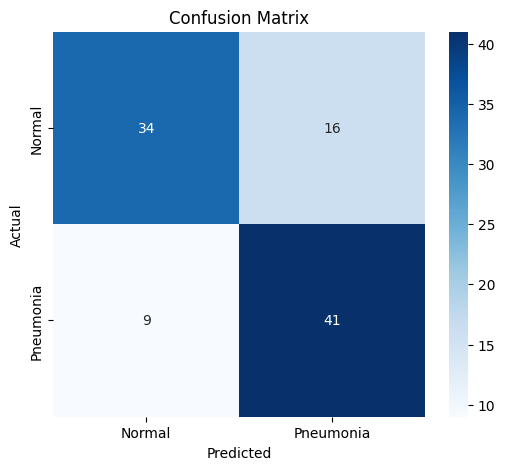

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions from your test loop (ensure they are on CPU)
# all_labels and all_preds should be the lists/tensors you created in the eval loop
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()